In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# import utils
import time
from urllib.request import urlretrieve
from os.path import isfile,isdir
from tqdm import tqdm
import zipfile
from sklearn.manifold import TSNE
from collections import Counter

In [0]:
folder='data'
filename='text8.zip'
name='Text8 Dataset'

class DLProgress(tqdm):
  last_block=0
  
  def hook(self,block_num=1,block_size=1,total_size=None):
    self.total=total_size
    self.update((block_num-self.last_block)*block_size)
    self.last_block=block_num
    
if not isfile(filename):
  with DLProgress(unit='B',unit_scale=True,miniters=1,desc=name) as pbar:
    urlretrieve('http://mattmahoney.net/dc/text8.zip',filename,pbar.hook)
    
if not isdir(folder):
  with zipfile.ZipFile(filename) as zip_ref:
    zip_ref.extractall(folder)
    
with open('data/text8') as f:
  text=f.read()

Text8 Dataset: 31.4MB [00:41, 755kB/s]                            


In [0]:
def preprocess(text):

    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words

In [0]:
words=preprocess(text)

In [0]:
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [0]:
print(len(words))
print(len(set(words)))

16680599
63641


In [0]:
def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: A tuple of dicts.  The first dict....
    """
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

In [0]:
vocab_to_int,int_to_vocab=create_lookup_tables(words)

In [0]:
int_words=[vocab_to_int[word] for word in words]

In [0]:
import random
threshold=1e-5
word_counts=Counter(int_words)
total_count=len(int_words)
freqs={word:count/total_count for word,count in word_counts.items()}
p_drop={word:1-np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words=[word for word in int_words if random.random()<(1-p_drop[word])]

In [0]:
def get_target(words,idx,window_size=5):
  R=np.random.randint(1,window_size+1)
  start=idx-R if (idx-R)>0 else 0
  end=idx+R
  target_words=set(words[start:idx]+words[idx+1:end+1])
  return list(target_words)

In [0]:
def get_batches(words,batch_size,window_size=5):
  n_batches=len(words)//batch_size
  
  words=words[:n_batches*batch_size]
  for idx in range(0,len(words),batch_size):
    x,y=[],[]
    batch=words[idx:idx+batch_size]
    for ii in range(len(batch)):
      batch_x=batch[ii]
      batch_y=get_target(batch,ii,window_size)
      x.extend([batch_x]*len(batch_y))
      y.extend(batch_y)
    yield x,y

In [0]:
train_graph=tf.Graph()
with train_graph.as_default():
  inputs=tf.placeholder(tf.int32,[None],name='inputs')
  labels=tf.placeholder(tf.int32,[None,None],name='labels')

In [0]:
n_vocab=len(int_to_vocab)
n_embedding=200
with train_graph.as_default():
  embedding=tf.Variable(tf.random_uniform((n_vocab,n_embedding),-1,1))
  embed=tf.nn.embedding_lookup(embedding,inputs)

##Negative Sampling:

In [0]:
n_sampled=100
with train_graph.as_default():
  softmax_w=tf.Variable(tf.truncated_normal((n_vocab,n_embedding),stddev=0.1))
  softmax_b=tf.Variable(tf.zeros(n_vocab))
  
  loss=tf.nn.sampled_softmax_loss(softmax_w,softmax_b,labels,embed,n_sampled,n_vocab)
  
  cost=tf.reduce_mean(loss)
  optimizer=tf.train.AdamOptimizer().minimize(cost)

In [0]:
with train_graph.as_default():
  valid_size=16
  valid_window=100
  valid_examples=np.array(random.sample(range(valid_window),valid_size//2))
  valid_examples=np.append(valid_examples,random.sample(range(1000,1000+valid_window),valid_size//2))
  valid_dataset=tf.constant(valid_examples,dtype=tf.int32)
  
  norm=tf.sqrt(tf.reduce_sum(tf.square(embedding),1,keepdims=True))
  normalized_embedding=embedding/norm
  valid_embedding=tf.nn.embedding_lookup(normalized_embedding,valid_dataset)
  similarity=tf.matmul(valid_embedding,tf.transpose(normalized_embedding))

In [0]:
!mkdir checkpoints

In [0]:
epochs=10
batch_size=1000
window_size=10

with train_graph.as_default():
  saver=tf.train.Saver()
  
with tf.Session(graph=train_graph) as sess:
  iteration=1
  loss=0
  sess.run(tf.global_variables_initializer())

  for e in range(1,epochs+1):
    batches=get_batches(train_words,batch_size,window_size)
    start=time.time()
    for x,y in batches:
      feed={inputs:x,
           labels:np.array(y)[:,None]}
      train_loss,_=sess.run([cost,optimizer],feed_dict=feed)
      loss+=train_loss
      if iteration % 100 == 0: 
          end = time.time()
          print("Epoch {}/{}".format(e, epochs),
                "Iteration: {}".format(iteration),
                "Avg. Training loss: {:.4f}".format(loss/100),
                "{:.4f} sec/batch".format((end-start)/100))
          loss = 0
          start = time.time()

      if iteration % 1000 == 0:
          # note that this is expensive (~20% slowdown if computed every 500 steps)
          sim = similarity.eval()
          for i in range(valid_size):
              valid_word = int_to_vocab[valid_examples[i]]
              top_k = 8 # number of nearest neighbors
              nearest = (-sim[i, :]).argsort()[1:top_k+1]
              log = 'Nearest to %s:' % valid_word
              for k in range(top_k):
                  close_word = int_to_vocab[nearest[k]]
                  log = '%s %s,' % (log, close_word)
              print(log)

      iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

In [0]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

W0629 21:02:12.863904 139771201255296 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [0]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

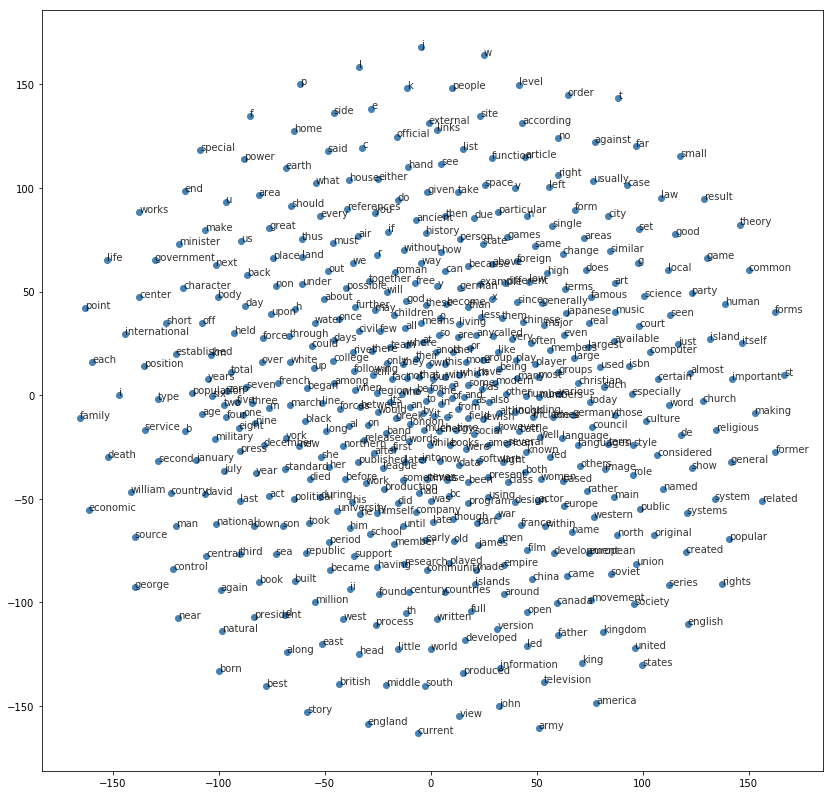

In [0]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.8)